<a href="https://colab.research.google.com/github/f1shstyxx/DS_capstone/blob/main/Project_3_LLM/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**next steps:**
* try pegasus
* remove overly short dialogues or summaries (<10 words) [COMPLETE]
* try learning rates like 3e-5, 1e-4 [SKIP]
* use cosine learning rate scheduler [COMPLETE]
* increase num_beams (4-6) for faster training. 10 takes up too much GPU memory. keep at 4 [COMPLETE]
* early stopping trainer = trainer (...,callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] [SKIP]

# Project 3 - Supervised Learning for Text Summarization

## Business Understanding

### Background

### Dataset Details

### Project Goals

### Project Considerations

## Data Understanding

In [2]:
# install mlflow, evaluate, rouge_score and datasets
!pip install -q mlflow
!pip install -q evaluate
!pip install -q rouge_score

# install hugging face
!pip install -q datasets

!pip install -q ipywidgets


In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
  accuracy_score, ConfusionMatrixDisplay
from transformers import BertTokenizer, EncoderDecoderModel, TrainingArguments,\
  Trainer, DataCollatorForSeq2Seq
import transformers
from transformers import EarlyStoppingCallback
import mlflow
import mlflow.transformers
import evaluate

# set random seed for reproducibility
def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

In [ ]:
# load samsum dataset
from datasets import load_dataset

# time the dataset loading
start_time = time.time()

# load samsum dataset
dataset = load_dataset('knkarthick/samsum')

end_time = time.time()
print(f"Dataset loaded in {(end_time - start_time)/60:.2f} minutes")

Dataset loaded in 0.03 minutes


In [ ]:
# explore the samsum dataset structure
print(f"Details of samsum dataset:\n")
print(dataset)

Details of samsum dataset:

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})


In [ ]:
# print first line from the train split of the samsum dataset

print(dataset['train'][0])

{'id': '13818513', 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)", 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}


In [ ]:
# convert train, validation and test splits to dataframes for EDA
# pandas dfs are better for quick exploration than Hugging Face datasets
# hugging face dataset objects are good for modeling, but less flexible for:
# describe(), filtering, plotting, sample inspection

df_train = pd.DataFrame(dataset['train'])
print(f"First 5 lines of the train split of SAMsum dataset:\n", df_train.head())

df_val = pd.DataFrame(dataset['validation'])
print(f"\nFirst 5 lines of the validation split of SAMsum dataset:\n", df_val.head())

df_test = pd.DataFrame(dataset['test'])
print(f"\nFirst 5 lines of the test split of SAMsum dataset:\n", df_test.head())

         id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\nSam: i...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  
         id                                           dialogue  \
0  13817023  A: Hi Tom, are you busy tomorrow’s afternoon?\...   
1  13716628  Emma: I’ve just fallen in love with this adven...   
2  13829420  Jackie: Madison is pregnant\nJackie: but she d...   
3  138196

### Text Exploration
Analyze the characteristics of the dialogues and summaries

In [8]:
# train df basic info and describe
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB
None
              id                                           dialogue  \
count      14732                                              14731   
unique     14732                                              14255   
top     13818513  Jimmy: Hey, guess what? My car's completely ka...   
freq           1                                                  4   

                                                  summary  
count                                               14732  
unique                                              14730  
top     Seth's pet Oreo that he got when he was 10 is ...  
freq                                                    2  

In [9]:
# length of train df
print(f"Length of train df: {len(df_train)}")

Length of train df: 14732


In [10]:
# text length analysis
# analysis will include speaker names

# create a new column 'dialogue_length' in df_train by taking 'dialogue' column and splitting the string and finding its length
df_train['dialogue_length'] = df_train['dialogue'].apply(lambda x: len(str(x).split()))

# calculate statistics of dialogue lengths
print("----- Dialogue Length Statistics -----")
print(f"\nAverage dialogue length: {df_train['dialogue_length'].mean():.2f} words")
print(f"\nMedian dialogue length: {df_train['dialogue_length'].median():.2f} words")
print(f"\nMinimum dialogue length: {df_train['dialogue_length'].min()} words")
print(f"\nMaximum dialogue length: {df_train['dialogue_length'].max()} words")

----- Dialogue Length Statistics -----

Average dialogue length: 93.79 words

Median dialogue length: 73.00 words

Minimum dialogue length: 1 words

Maximum dialogue length: 803 words


In [11]:
# create new column 'summary_length' in df_train by taking 'summary' column and splitting the string and finding its length
df_train['summary_length'] = df_train['summary'].apply(lambda x: len(str(x).split()))

# calculate statistics of summary lengths
print("----- Summary Length Statistics -----")
print(f"\nAverage summary length: {df_train['summary_length'].mean():.2f} words")
print(f"\nMedian summary length: {df_train['summary_length'].median():.2f} words")
print(f"\nMinimum summary length: {df_train['summary_length'].min()} words")
print(f"\nMaximum summary length: {df_train['summary_length'].max()} words")

----- Summary Length Statistics -----

Average summary length: 20.32 words

Median summary length: 18.00 words

Minimum summary length: 1 words

Maximum summary length: 64 words


In [ ]:
# check for missing values in the dataframes
print(f"\nMissing values in df_train:\n")
print(f"Missing values in df_train:\n")
print(df_train.isnull().sum())

print(f"\nMissing values in df_validation:\n")
print(df_val.isnull().sum())

print(f"\nMissing values in df_test:\n")
print(df_test.isnull().sum())

Missing values in df_train:

id                 0
dialogue           1
summary            0
dialogue_length    0
summary_length     0
dtype: int64

Missing values in df_validation:

id          0
dialogue    0
summary     0
dtype: int64

Missing values in df_test:

id          0
dialogue    0
summary     0
dtype: int64


In [ ]:
# drop the row from df_train with missing value in dialogue column
df_train = df_train.dropna(subset=['dialogue'])
print(f"Missing values in df_train:\n")
print(df_train.isnull().sum())
print(f"\nLength of train df: {len(df_train)}")

Missing values in df_train:

id                 0
dialogue           0
summary            0
dialogue_length    0
summary_length     0
dtype: int64

Length of train df: 14731


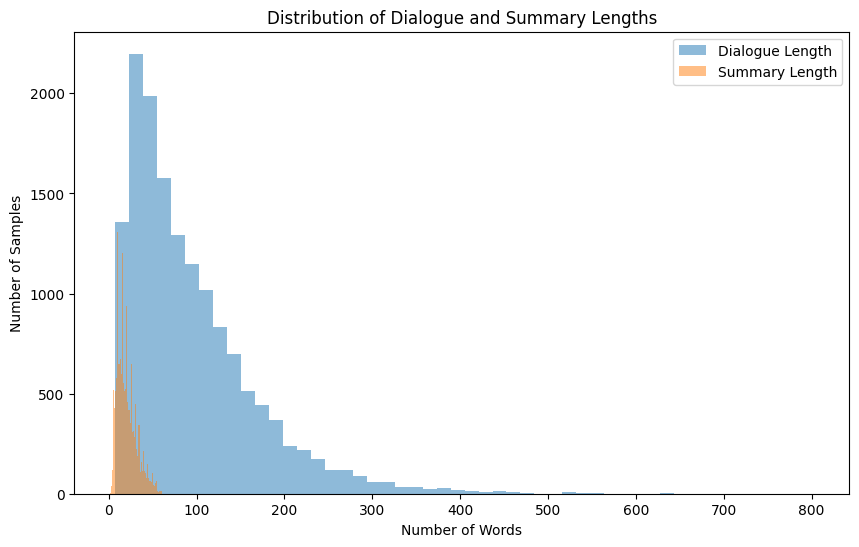

In [14]:
# plot dialogue vs summary lengths for df_train
plt.figure(figsize=(10, 6))
plt.hist(df_train['dialogue_length'], bins=50, alpha=0.5, label='Dialogue Length')
plt.hist(df_train['summary_length'], bins=50, alpha=0.5, label='Summary Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Distribution of Dialogue and Summary Lengths')
plt.legend()
plt.show()

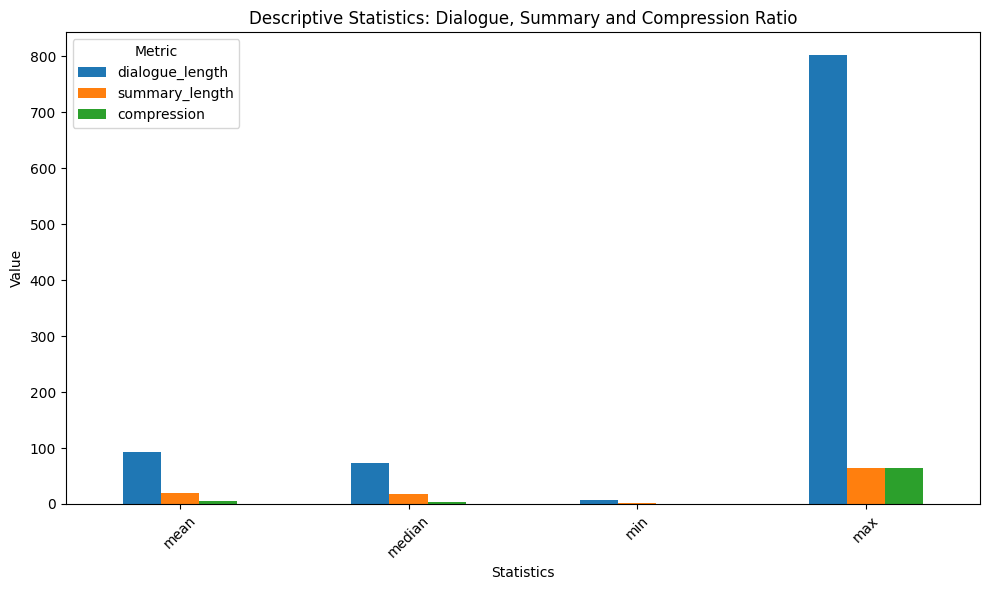

In [15]:
# plot dialogue, summary, and compression statistics for df_train
df_train['compression'] = df_train['dialogue_length'] / df_train['summary_length']
stats = df_train[['dialogue_length', 'summary_length', 'compression']].agg(['mean', 'median', 'min', 'max']).round(2).T

# plot statistics
stats.T.plot(kind='bar', figsize=(10,6))
plt.title('Descriptive Statistics: Dialogue, Summary and Compression Ratio')
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [ ]:
# examples of dialogue and summary from df_train

print(f"Dialogue #1 from df_train:")
print(f"\nDialogue:\n{df_train['dialogue'][1]}")
print(f"\nSummary:\n{df_train['summary'][1]}")

print(f"\nDialogue #2 from df_train:")
print(f"\nDialogue:\n{df_train['dialogue'][1000]}")
print(f"\nSummary:\n{df_train['summary'][1000]}")

print(f"\nDialogue #3 from df_train:")
print(f"\nDialogue:\n{df_train['dialogue'][10000]}")
print(f"\nSummary:\n{df_train['summary'][10000]}")


Dialogue:
Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great

Summary:
Olivia and Olivier are voting for liberals in this election. 

Dialogue:
Ann: Do you have plans for the holidays this year?
Mary: Well we thought of going for a hike somewhere beautiful
Mary: and you?
Ann: We talked about it last night and we thought maybe you would like to do sth together?
Mary: Why not
Mary: just remember that we're outdoorsy people :D
Ann: I know, but you're not even considering a nice beach somewhere?
Mary: weeeeell, that's not really us, you know?
Mary: we prefer tents and hiking boots to bikinis and sunscreen ;)
Ann: I see.
Ann: I'm not sure I'm ready for a longer hike but maybe we could go somewhere like that for a weekend so I can try it?
Mary: That would be great!
Mary: I'm sure you'll love it just like we do :)
Ann: the idea of spending you time in the woods sure is romantic, but i'm not sure I'll remember that when bugs qill be ea

## Data Preparation

In [17]:
# remove dialogues with fewer than 10 words
min_dialogue_length = 10

def is_long_enough(example):
  return example['dialogue'] is not None and len(example['dialogue'].split()) >= min_dialogue_length

# apply filter to each dataset split
dataset['train'] = dataset['train'].filter(is_long_enough)
dataset['validation'] = dataset['validation'].filter(is_long_enough)
dataset['test'] = dataset['test'].filter(is_long_enough)

Prep data for input to BERT model
* implement appropriate tokenization
* create training and validation splits
* build data loaders for efficient model training

In [18]:
# initialize tokenizer
# converts input dialogue into token IDs for the encoder
# converts target summary into token IDs for the decoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 64

# define tokenize function
def tokenize_function(batch):

  # tokenize input dialogue
  inputs = tokenizer(
      batch['dialogue'],
      padding='max_length',
      truncation=True,
      max_length = MAX_INPUT_LENGTH,
  )

  # tokenize target summary
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        batch['summary'],
        padding='max_length',
        truncation=True,
        max_length=MAX_TARGET_LENGTH,
  )

  # attach labels to inputs
  inputs['labels'] = labels['input_ids']
  return inputs

In [ ]:
# tokenize train, validation, and test splits

start_time = time.time()

# Remove examples with None in 'dialogue' or 'summary'
dataset['train'] = dataset['train'].filter(lambda x: x['dialogue'] is not None and x['summary'] is not None)

tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_val = dataset['validation'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

end_time = time.time()
print(f"Tokenization time: {(end_time - start_time)/60:.2f} minutes")

# Tokenization time: 50 sec on 7/25/25

Tokenization time: 0.01 minutes


In [20]:
# load a BERT2BERT pre-trained model (encoder-decoder)
# use patrickvonplaten/bert2bert-cnn_dailymail-fp16 as a BERT2BERT model fine-tuned on CNN/DailyMail
# encoder and decoder both use bert-case-uncased
# bert-case-uncased is a commonly used pretrained BERT model from the original BERT paper

model = EncoderDecoderModel.from_pretrained('patrickvonplaten/bert2bert-cnn_dailymail-fp16')

Some weights of the model checkpoint at patrickvonplaten/bert2bert-cnn_dailymail-fp16 were not used when initializing EncoderDecoderModel: ['decoder.bert.pooler.dense.bias', 'decoder.bert.pooler.dense.weight']
- This IS expected if you are initializing EncoderDecoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EncoderDecoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# configure the model for the summarization task

# start of decoding, for BERT based decoders, CLS is used
model.config.decoder_start_token_id = tokenizer.cls_token_id

# end of sequence token, SEP used for BERT
model.config.eos_token_id = tokenizer.sep_token_id

# padding for batches
model.config.pad_token_id = tokenizer.pad_token_id

# ensures encoder and decoder share the same vocab size
model.config.vocab_size = model.config.encoder.vocab_size

## Modeling

In [ ]:
# set up training arguments for model training (summarization)

training_args = TrainingArguments(
    # core argument
    output_dir="./bert2bert_samsum",    # save model checkpoints, logs, etc.
    save_steps=500,         # save a checkpoint every 500 steps, for recovery or versioning
    save_total_limit=2,     # keep only the last 2 saved models
    logging_steps=500,      # log training loss and metrics every 500 steps
    do_train=True,          # enable training
    do_eval=True,           # enable eval during training on eval dataset
    do_predict=True,        # make predictions after training

    # training configuration
    per_device_train_batch_size=4,  # batch size per device for training
    per_device_eval_batch_size=4,   # batch size per device for evaluation
    num_train_epochs=3,             # number of times the model will see the full dataset
    learning_rate=5e-5,             # how quickly the model updates weights
    lr_scheduler_type="cosine",     # how learning rate changes over time
                                    # linear gradually decreases, or cosine, constant
    warmup_steps=500,               # num of steps to slowly ramp up learning rate
                                    # before stabilizing. helps avoid bad initial updates

    # performance optimization
    fp16=True,              # reduce memory usage and speed up training

    # monitoring and model selection
    metric_for_best_model="rougeL",
    greater_is_better=True,         # True if higher metric values are better (ROUGE)
    report_to="tensorboard",        # enables TensorBoard logging
)

# 2. Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 3. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

C:\Users\jtlee\AppData\Local\Temp\ipykernel_5392\3371518707.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# train the model and log the training process with MLflow

start_time = time.time()

mlflow.set_experiment("BERT2BERT SAMSum")

with mlflow.start_run():
    mlflow.log_param("model", "bert2bert-cnn_dailymail-fp16")
    mlflow.log_param("epochs", 3)
    mlflow.log_param("batch_size", 4)

    # Start training
    trainer.train()

    # Log final model and tokenizer
    model.save_pretrained("./bert2bert_samsum_final")
    tokenizer.save_pretrained("./bert2bert_samsum_final")

    mlflow.log_artifacts("./bert2bert_samsum_final", artifact_path="model")

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

# training time: 51 minutes on 7/25/25
# training time: 42 minutes on 7/26/25 w/ 3 epochs
# training time: 71 min on 7/26/25 w/ 3 epochs (from MLflow)
# training time: 66.8 min on 7/27/25 w/ 5 epochs
# training time: 67 min on 7/27/25 w/ 10 epochs
# training time: 40 min on 7/27/25 w/ 3 epochs
# training time: 47 min on 7/29/25 w/ 3 epochs
# training time: 40 min on 7/29/25 w/ 3 epochs and batch size 4

c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder its

Step,Training Loss
500,2.219500
1000,1.017600
1500,0.983000
2000,0.957700
2500,0.924500
3000,0.940000
3500,0.919800
4000,0.792800
4500,0.714400
5000,0.721300


c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\transformers\modeling_utils.py:3854: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies i

Training time: 40.74 minutes


view MLflow UI by running:
mlflow ui


In [36]:
# reload model and tokenizer
import torch

tokenizer = BertTokenizer.from_pretrained("./bert2bert_samsum_final")
model = EncoderDecoderModel.from_pretrained("./bert2bert_samsum_final")

# move model to device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [39]:
start_time = time.time()

# Redefine training arguments (can extend epochs)
training_args = TrainingArguments(
    output_dir="./bert2bert_samsum",
    save_steps=500,
    save_total_limit=2,
    logging_steps=500,
    do_train=True,
    do_eval=True,
    do_predict=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,  # increase this for additional epochs
    learning_rate=5e-5,
    lr_scheduler_type="cosine",   # try linear and cosine
    warmup_steps=500,
    fp16=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    report_to="tensorboard"
)

# Redefine data collator and trainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,  # should be already in memory
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()  # resume training from last checkpoint

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

# training time: 67 min on 7/27/25 w/ 10 epochs

C:\Users\jtlee\AppData\Local\Temp\ipykernel_5392\914670505.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.374600
1000,0.249800
1500,0.258700
2000,0.523400
2500,0.530700
3000,0.552300
3500,0.550100
4000,0.428300
4500,0.360400
5000,0.371800


c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.5

Training time: 96.20 minutes


## Evaluation

use ROUGE (Recall-Oriented Understudy for Gisting Evaluation) to compare the overlap between generated summaries and reference summaries.

In [40]:
from torch.utils.data import Subset

# inspect how well the model summarizes dialogues from the test set

# Get 5 evenly spaced indices from the test set
indices = np.linspace(0, len(dataset['test']) - 1, num=5, dtype=int)

# Cast each to Python int explicitly
raw_samples = [dataset['test'][int(i)] for i in indices]

# Tokenize the dialogues
inputs = tokenizer(
    [sample['dialogue'] for sample in raw_samples],
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512,
).to(model.device)

# Generate summaries with trained model
output_ids = model.generate(
    **inputs,
    max_length=64,                # already used
    min_length=20,                # optional, for preventing too short outputs
    length_penalty=1.2,           # >1.0 discourages long outputs
    num_beams=4,                  # better than greedy (1)
    early_stopping=True,          # stop when an EOS token is reached
    no_repeat_ngram_size=3        # prevents repetition
)

# Decode output tokens into readable text
decoded_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
decoded_labels = [sample['summary'] for sample in raw_samples]

# Show prediction (generated summaries) vs. reference (ground truth summaries)
for i in range(len(decoded_preds)):
    print(f"\n--- Example {i+1} ---")
    print(f"Dialogue:\n{raw_samples[i]['dialogue']}")
    print(f"\nGenerated Summary:\n{decoded_preds[i]}")
    print(f"\nReference Summary:\n{decoded_labels[i]}")

c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
`cache.key_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].keys` instead.
`cache.value_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].values` instead.



--- Example 1 ---
Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Generated Summary:
hannah is looking for betty's number. she will ask larry if he's nice.

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

--- Example 2 ---
Dialogue:
Kamden: Hey!
Mckinley: Hi!
Kamden: I haven't seen you in a while - i've mostly been off social media. Maybe you'll let me have a little peek?
Mckinley: You aren't on fb anymore?
Kamden: I use chat on fb. I'm not big on social media use
Mckinley: Hmm...
Kamden: It helps me keep up with good friends
Mckinley: But you always can open it and

In [41]:
# add progress bar to see how many iterations are left
from tqdm import tqdm

decoded_preds = []
decoded_labels = []

# loop over test dataset, one dialogue at a time
for idx in tqdm(range(len(dataset['test']))):
    # Get one dialogue and ground truth summary
    dialogue = dataset['test'][int(idx)]['dialogue']
    reference = dataset['test'][int(idx)]['summary']

    # tokenize the dialogue and convert into input tensors
    inputs = tokenizer(dialogue, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)

    # Generate one summary
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=64,
            min_length=20,
            length_penalty=1.2,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    # Decode output and store
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    decoded_preds.append(summary)
    decoded_labels.append(reference)

    # # Print result
    # print(f"\n--- Example {idx} ---")
    # print(f"Dialogue:\n{dialogue}")
    # print(f"\nGenerated Summary:\n{summary}")
    # print(f"\nReference Summary:\n{reference}")

    # clear memory after each loop to avoid CUDA memory issues
    torch.cuda.empty_cache()

100%|██████████| 814/814 [07:07<00:00,  1.90it/s]


In [42]:
start_time = time.time()

# load ROUGE evaluation model from evaluate library
rouge = evaluate.load("rouge")

# Clean predictions and labels
decoded_preds_clean = [pred.strip() for pred in decoded_preds]
decoded_labels_clean = [label.strip() for label in decoded_labels]

# Compute ROUGE scores
# ROUGE-1 = unigram overlap
# ROUGE-2 = bigram overlap
# ROUGE-L = longest common subsequence
# ROUGE-Lsum = ROUGE-L for summaries
results = rouge.compute(predictions=decoded_preds_clean, references=decoded_labels_clean)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


end_time = time.time()
print(f"Evaluation time: {(end_time - start_time)/60:.2f} minutes")

rouge1: 0.4286
rouge2: 0.1763
rougeL: 0.3366
rougeLsum: 0.3358
Evaluation time: 0.02 minutes


In [43]:
from tqdm import tqdm  # Add this import if not already present

def generate_summaries_in_batches(dialogues=None, batch_size=8):
    if dialogues is None:
        dialogues = dataset['test']['dialogue']
    generated = []
    model.eval()  # switch to inference mode

    # Wrap the loop with tqdm for progress monitoring
    for i in tqdm(range(0, len(dialogues), batch_size), desc="Generating summaries"):
        batch = dialogues[i:i + batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_length=64,
                min_length=20,
                num_beams=4,
                no_repeat_ngram_size=3,
                early_stopping=True
            )

        batch_summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        generated.extend(batch_summaries)

        # optional: free GPU memory between batches
        torch.cuda.empty_cache()

    return generated

generated_summaries = generate_summaries_in_batches(batch_size=2)

Generating summaries: 100%|██████████| 407/407 [04:08<00:00,  1.64it/s]


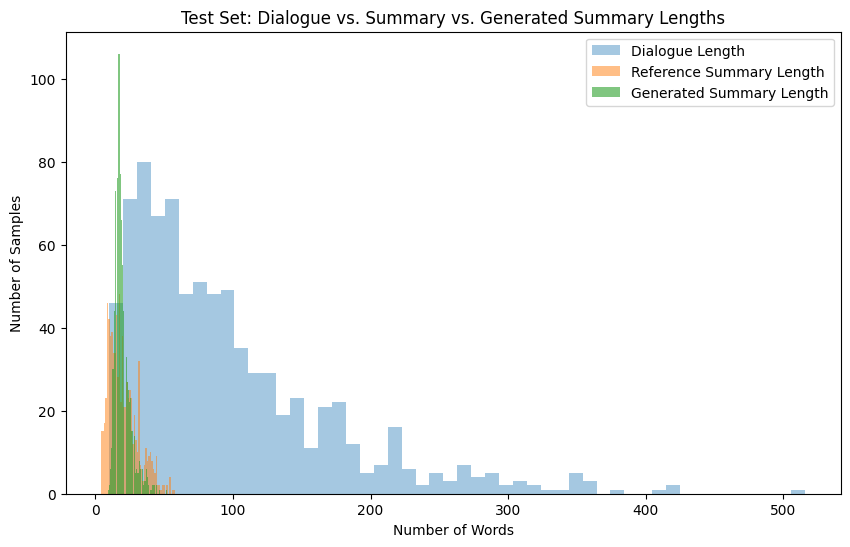

In [44]:
# visualize test dialogue vs summary vs generated summary lengths

# Compute lengths
test_dialogue_lengths = [len(d.split()) for d in dataset['test']['dialogue']]
test_ref_summary_lengths = [len(s.split()) for s in dataset['test']['summary']]

# model outputs
test_gen_summary_lengths = [len(s.split()) for s in generated_summaries]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(test_dialogue_lengths, bins=50, alpha=0.4, label='Dialogue Length')
plt.hist(test_ref_summary_lengths, bins=50, alpha=0.5, label='Reference Summary Length')
plt.hist(test_gen_summary_lengths, bins=50, alpha=0.6, label='Generated Summary Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Test Set: Dialogue vs. Summary vs. Generated Summary Lengths')
plt.legend()
plt.show()

Visually, the generated summaries are similar in length to the reference summaries.

In [46]:
# # Compute word lengths
# test_dialogue_length = [len(d.split()) for d in dataset['test']['dialogue']]
# test_summary_length = [len(s.split()) for s in dataset['test']['summary']]
# test_generated_length = [len(s.split()) for s in generated_summaries]

# Compute compression ratios
test_compression_ref = [d/s if s != 0 else 0 for d, s in zip(test_dialogue_lengths, test_ref_summary_lengths)]
test_compression_gen = [d/s if s != 0 else 0 for d, s in zip(test_dialogue_lengths, test_gen_summary_lengths)]

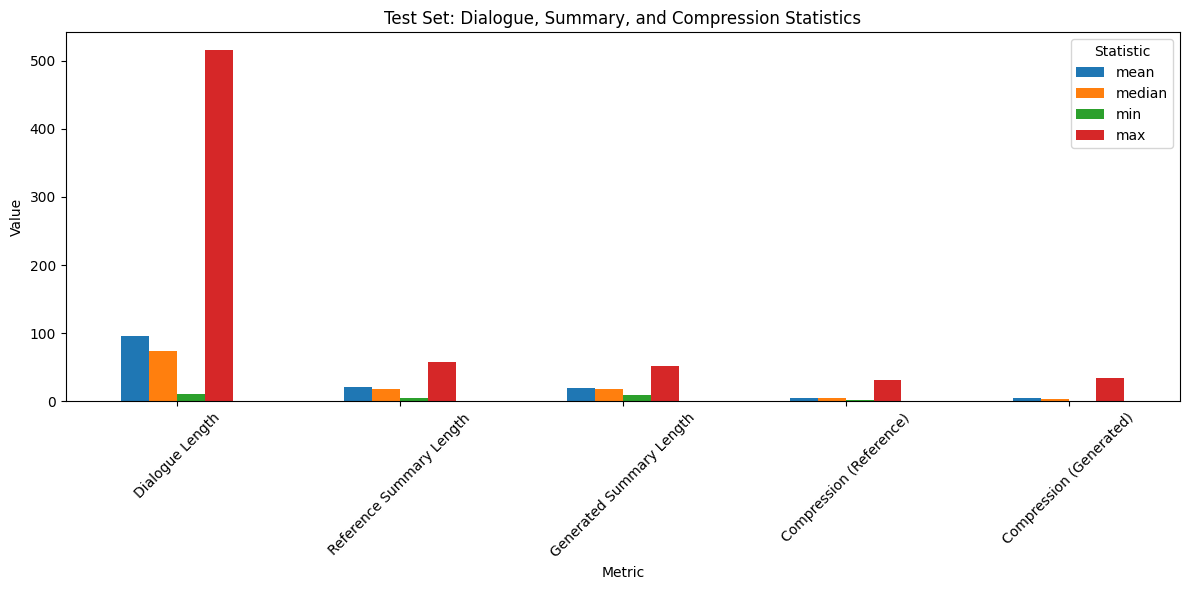

In [47]:
# visualize test dialogue vs summary vs generated summary lengths and compression ratios
df_stats = pd.DataFrame({
    "Dialogue Length": test_dialogue_lengths,
    "Reference Summary Length": test_ref_summary_lengths,
    "Generated Summary Length": test_gen_summary_lengths,
    "Compression (Reference)": test_compression_ref,
    "Compression (Generated)": test_compression_gen
})

# Aggregate statistics
summary_stats = df_stats.agg(['mean', 'median', 'min', 'max']).round(2).T

summary_stats.plot(kind='bar', figsize=(12, 6))
plt.title('Test Set: Dialogue, Summary, and Compression Statistics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Statistic')
plt.tight_layout()
plt.show()

In [48]:
# load seddiktrk/pegasus-samsum

from transformers import PegasusTokenizer, PegasusForConditionalGeneration

model_pegasus = "seddiktrk/pegasus-samsum"

tokenizer = PegasusTokenizer.from_pretrained(model_pegasus)
model_pegasus = PegasusForConditionalGeneration.from_pretrained(model_pegasus)

In [49]:
# Pick a sample dialogue
dialogue = dataset['test'][42]['dialogue']
reference = dataset['test'][42]['summary']

# Tokenize
inputs = tokenizer(dialogue, return_tensors="pt", truncation=True, padding=True).to(model_pegasus.device)

# Generate summary
summary_ids = model_pegasus.generate(
    **inputs,
    max_length=64,
    min_length=20,
    num_beams=4,
    early_stopping=True
)

# Decode output
generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Show result
print("Dialogue:\n", dialogue)
print("\nReference Summary:\n", reference)
print("\nGenerated Summary (Pegasus):\n", generated_summary)

Dialogue:
 Ola: Hello Kate, sorry for not keeping in touch properly. As expected, we have hardly any connectivity here in Cuba. But we're doing fine and enjoying our trip. How are the things at home?
Kate: At long last! Started to worry. Nothing new happening, if you disregard all that Xmas craze. Momo has recovered from her injury and frolicking again.
Kate: <file_photo>
Kate: Good old Momo! Yes, it is your scarf!
Ola: NO!!! It's one of my favorites! The one from Laos!
Kate: Too late. Momo thinks it belongs to her now. Get yourself a new one. They surely have nice ones there.
Ola: Not at all. Only cheapish cotton blouses with horrible multi-coloured embroidery or some equally horrible crochetted tops. No shawls or scarfs.
Ola: <file_photo>
Kate: Wait a sec!
Kate: <file_photo>
Kate: Isn't it similar?! Mum would probably like it. Why don't you?
Ola: Not a bad idea. But the quality is usually crappy.
Kate: And if you go to some boutique shop or something? Not at a market as in your pics?

In [53]:
def generate_pegasus_batch(dialogues, batch_size=8):
    summaries = []
    model_pegasus.eval()
    for i in tqdm(range(0, len(dialogues), batch_size), desc="Pegasus summaries"):
        batch = dialogues[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model_pegasus.device)
        with torch.no_grad():
            outputs = model_pegasus.generate(
                **inputs,
                max_length=64,
                min_length=20,
                num_beams=4,
                early_stopping=True
            )
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        summaries.extend(decoded)
        torch.cuda.empty_cache()
    return summaries

pegasus_summaries = generate_pegasus_batch(dataset['test']['dialogue'], batch_size=2)
pegasus_rouge = rouge.compute(
    predictions=[s.strip() for s in pegasus_summaries],
    references=[s.strip() for s in dataset['test']['summary']]
)


Pegasus summaries: 100%|██████████| 407/407 [26:49<00:00,  3.95s/it]


In [54]:
pegasus_summaries = generate_pegasus_batch(dataset['test']['dialogue'], batch_size=2)
pegasus_rouge = rouge.compute(
    predictions=[s.strip() for s in pegasus_summaries],
    references=[s.strip() for s in dataset['test']['summary']]
)

Pegasus summaries: 100%|██████████| 407/407 [27:46<00:00,  4.09s/it]


In [ ]:
# evaluate.load('rouge')  # Load ROUGE evaluation model

# # Clean prediction and reference (strip whitespace)
# prediction = generated_summary.strip()
# reference = reference.strip()

# # Compute ROUGE
# results = rouge.compute(predictions=[prediction], references=[reference])

# # Display results
# for key, value in results.items():
#     print(f"{key}: {value:.4f}")


rouge1: 0.5556
rouge2: 0.3429
rougeL: 0.4722
rougeLsum: 0.4722


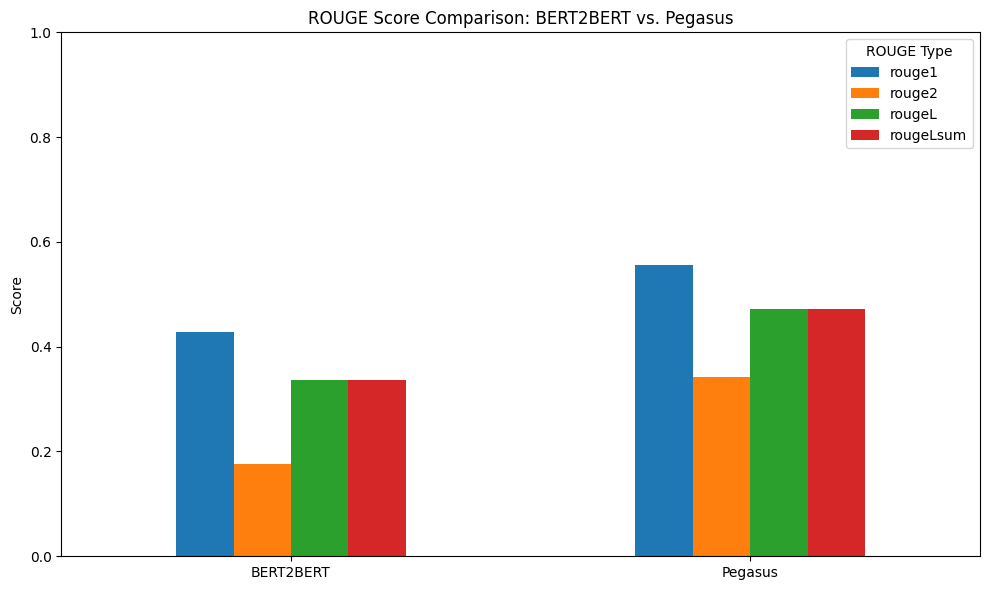

In [56]:
# BERT2BERT full test set ROUGE
bert_rouge = rouge.compute(predictions=decoded_preds_clean, references=decoded_labels_clean)

# Pegasus single example ROUGE
pegasus_rouge = rouge.compute(predictions=[generated_summary.strip()], references=[reference.strip()])

# Combine into a DataFrame
rouge_df = pd.DataFrame({
    'BERT2BERT': bert_rouge,
    'Pegasus': pegasus_rouge
})
# Transpose for better plotting
rouge_df.T.plot(kind='bar', figsize=(10, 6))
plt.title("ROUGE Score Comparison: BERT2BERT vs. Pegasus")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title="ROUGE Type")
plt.tight_layout()
plt.show()

# Notes on model performance
# - Model captures structure of conversations well.
# - Struggles with informal/abrupt phrases or very long dialogues.
# - Sometimes over-summarizes or paraphrases too freely.

# Conclusion